# Assignment 3

# Instructions

1. You have to use only this notebook for all your code.
2. All the results and plots should be mentioned in this notebook.
3. For final submission, submit this notebook along with the report ( usual 2-4 pages, latex typeset, which includes the challenges faces and details of additional steps, if any)
4. Marking scheme
    -  **60%**: Your code should be able to detect bounding boxes using resnet 18, correct data loading and preprocessing. Plot any 5 correct and 5 incorrect sample detections from the test set in this notebook for both the approached (1 layer and 2 layer detection), so total of 20 plots.
    -  **20%**: Use two layers (multi-scale feature maps) to detect objects independently as in SSD (https://arxiv.org/abs/1512.02325).  In this method, 1st detection will be through the last layer of Resnet18 and the 2nd detection could be through any layer before the last layer. SSD uses lower resolution layers to detect larger scale objects. 
    -  **20%**: Implement Non-maximum suppression (NMS) (should not be imported from any library) on the candidate bounding boxes.
    
5. Report AP for each of the three class and mAP score for the complete test set.

In [0]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
from torch import optim
from torch.optim import lr_scheduler
import torch.utils.data
import torch.nn as nn
from torchvision import transforms, datasets
import torchvision.models as models
from torch.autograd import Variable
from torchsummary import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
# Import other modules if required
import os
import sys
import xml.etree.ElementTree as ET
from PIL import Image
import imageio
from scipy.misc import imresize
from pathlib import Path
import copy
import time
from IPython.display import clear_output as clr
import tarfile
from sklearn.utils import class_weight as cw
from sklearn.metrics import precision_score as pscr
from google.colab import files
import cv2
# Can use other libraries as well

resnet_input = 224#size of resnet18 input images

In [0]:
# Choose your hyper-parameters using validation data
batch_size = 100
num_epochs = 5
learning_rate =  0.001
hyp_momentum = 0.9

In [3]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar 
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar 
traintar = tarfile.open("VOCtrainval_06-Nov-2007.tar")
traintar.extractall("./train_data")
traintar = tarfile.open("VOCtest_06-Nov-2007.tar")
traintar.extractall("./test_data")

--2019-03-21 04:13:51--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  12.8MB/s    in 36s     

2019-03-21 04:14:32 (12.3 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2019-03-21 04:14:33--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================

In [0]:
COLORS = np.array([[255,0,0],[0,255,0],[0,0,255]]).astype('float')

## Build the data
Use the following links to locally download the data:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>The dataset consists of images from 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, i.e. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the three classes(aeroplane, bottle, chair). For parsing the xml file, you can import xml.etree.ElementTree for you. <br/>
<br/> Organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be four. This is important for applying the sliding window method later.


In [0]:
trainval_path = "train_data/VOCdevkit/VOC2007"
test_path = "test_data/VOCdevkit/VOC2007"
anno = '/Annotations'
imgs = '/ImageSets'
jpeg = '/JPEGImages'
segc = '/SegmentationClass'
sego = '/SegmentationObject'
save = "/classes"
try:
    os.stat(trainval_path + save)
except:
    os.mkdir(trainval_path + save)
    
try:
    os.stat(test_path + save)
except:
    os.mkdir(test_path + save)

In [0]:
classes = ('__background__',
           'aeroplane',
           'bottle',
           'chair'
           )

class_labels = {
    '__background__' : 0,
    'aeroplane' : 1,
    'bottle' : 2,
    'chair' : 3,
}

In [0]:
def build_dataset(path):
    # Begin
    count = np.zeros((len(classes)))
    
    ## part 1 Image class based cropping and resizing
    for xml_path in os.listdir(path + anno):
        tree = ET.parse(path + anno + "/" + xml_path)
        image = Image.open(path + jpeg + "/" + tree.getroot()[1].text)
        image_arr = np.array(image)
        y0 = 0
        x0 = 0
        y1 = image_arr.shape[0]
        x1 = image_arr.shape[1]
        
        xout = 0
        xin  = 10000
        yout = 0
        yin  = 10000
        img_n_obj = 0
        
        for obj in tree.getroot().findall('object'):
            class_name = obj[0].text
            if(class_name in classes):
                img_n_obj+=1
                xmin = int(obj[4][0].text)
                ymin = int(obj[4][1].text)
                xmax = int(obj[4][2].text)
                ymax = int(obj[4][3].text)
                
                xout = max(xout, xmax)
                xin  = min(xin,  xmin)
                yout = max(yout, ymax)
                yin  = min(yin,  ymin)
                
                subimg = np.array(
                    Image.fromarray(
                        np.array(image)[ymin:ymax,xmin:xmax]
                    ).resize((resnet_input,resnet_input)))
                label = class_labels[class_name]
                try:
                    os.stat(path + save+"/"+str(label))
                except:
                    os.mkdir(path + save+"/"+str(label))
                subpath = path+save+"/"+str(label)+'/'+str(int(count[label]))+'.jpg'
                imageio.imwrite(subpath, subimg)
                count[label] += 1
           
        
         ## part 2 Image hard negative mining for negative class (Background)
        r1 = image_arr[yout:y1, :]
        r2 = image_arr[y0:yin, :]
        r3 = image_arr[: , x0:xin]
        r4 = image_arr[: , xout:x1]
        
        p1 = y1-yout
        p2 = yin-y0
        p3 = xin-x0
        p4 = x1-xout
        
        pvec = np.array([p1,p2,p3,p4])
        pvec = pvec/np.sum(pvec)
        
        bcount = 0
        infcount = 0
        
        while (bcount < (img_n_obj//3+3) and infcount < 10):
            infcount += 1
            try:
                bcount += 1
                img = np.random.choice([r1,r2,r3,r4], p = pvec)

                a0 = np.random.randint(0,img.shape[1])
                a1 = min(np.random.randint(a0,img.shape[1])+100,img.shape[1])
                b0 = np.random.randint(0,img.shape[0])
                b1 = min(np.random.randint(b0,img.shape[1])+100,img.shape[0])
#                 b1 = np.random.randint(b0,img.shape[0])

                back_img = np.array(
                        Image.fromarray(
                            img[b0:b1, a0:a1]
                        ).resize((resnet_input,resnet_input)))

                label = class_labels["__background__"]
                try:
                    os.stat(path + save+"/"+str(label))
                except:
                    os.mkdir(path + save+"/"+str(label))
                back_path = path+save+"/"+str(label)+'/'+str(int(count[label]))+'.jpg'
                imageio.imwrite(back_path, back_img)
                count[label] += 1
            except:
                pass

In [0]:
build_dataset(trainval_path)
build_dataset(test_path)

In [0]:
class voc_dataset(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # Begin
        self.root = os.path.expanduser(root_dir)
        self.transform = transform
        self.train = train
        
        self.train_transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.RandomRotation(45),
            transforms.RandomCrop(200),
        ])
                                         
        self.images = []
        self.labels = []
        folder_class = self.root + save
        for lbl in os.listdir(folder_class):
            folder_img = folder_class + "/" + lbl
            for img_name in os.listdir(folder_img):
                img_path = folder_img + "/" + img_name
                self.images.append(img_path)
                self.labels.append(int(lbl))
                
        self.random_indices = np.arange(len(self.labels))
        np.random.shuffle(self.random_indices)
        
        
    def __len__(self):
        # Begin
        return len(self.labels)
        
    def __getitem__(self, idx):
       # Begin
        a_idx = self.random_indices[idx]
        img = Image.open(self.images[a_idx]).convert('RGB')
        target = self.labels[a_idx]
        y_onehot = torch.tensor(target)
        
        if self.transform is not None:
          if(self.train):
            img = self.transform(img)
#             img = self.transform(self.train_transform(img))
          else:
            img = self.transform(img)
        
        if(train):
#           a,b,c = np.array(img).shape
#           img += torch.tensor(0.01*(np.random.rand(a,b,c) - 0.5)).type(torch.FloatTensor)
            pass
        return img,y_onehot

## Train the netwok
<br/>You can train the network on the created dataset. This will yield a classification network on the 4 classes of the VOC dataset. 

In [0]:
composed_transform = transforms.Compose([transforms.Resize((224,224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])
train_dataset = voc_dataset(root_dir=trainval_path, train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = voc_dataset(root_dir=test_path, train=False, transform=composed_transform) # Supply proper root_dir

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


####

dataloaders = {
    'train' : train_loader,
    'test' : test_loader
}

In [0]:
class_weights = cw.compute_class_weight('balanced',np.unique(train_dataset.labels), train_dataset.labels)

In [0]:
c_weights = (torch.tensor(class_weights).float()).cuda()

In [461]:
c_weights

tensor([0.4777, 3.7983, 1.9830, 0.8780], device='cuda:0')

### Fine-tuning
Use the pre-trained network to fine-tune the network in the following section:

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [0]:
device = 'cuda'
torch.device(device)
class BCNN(torch.nn.Module):
  
    def __init__(self, model,in_c, out_c, d):
        """Declare all needed layers."""
        torch.nn.Module.__init__(self)
        self.out_c = out_c
        self.d = d
        self.features = nn.Sequential(*list(model.to(device).children())).to(device)
        self.conv = nn.Conv2d(in_c, self.out_c, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.fc = nn.Linear(self.out_c**2,64).to(device)
        self.fc2 = nn.Linear(64,4).to(device)
        

    def forward(self, X):
      
        N = X.size()[0]
                                            
        X = self.conv(self.features(X))
        d = self.d                
        X = X.view(N, self.out_c, d**2)
        X = F.relu(X)
        X = torch.bmm(X, torch.transpose(X, 1, 2)) / (d**2)  # Bilinear
        X = X.view(N, self.out_c**2)
        X = torch.mul(torch.sign(X),torch.sqrt(torch.abs(X)+1e-12))
        X = torch.nn.functional.normalize(X)
        X = self.fc(X)
        X = F.relu(X)
        X = torch.mul(torch.sign(X),torch.sqrt(torch.abs(X)+1e-12))
        X = torch.nn.functional.normalize(X)
        X = self.fc2(X)        
        return X

In [0]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 256)
model = nn.Sequential(resnet18, nn.LeakyReLU(), nn.Linear(256,4))
# model.load_state_dict(torch.load('modelwts.h5'))

In [0]:
criterion = nn.CrossEntropyLoss(weight=c_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [466]:
model.to(device)
summary(model, (3,224,224))

# model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [0]:
#One Layer Detection
def train(model, criterion, optimizer, scheduler, num_epochs = 100):
    # Begin
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    avg_prec = 0.0
    best_map = 0.0
    
    
    epoch_loss = 1000.0
    epoch_acc = 0.0
    for epoch in range(num_epochs):
        start = time.time()
#         print('Current Epoch :', epoch, 'remaining :', num_epochs - epoch)
              
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            count = 0
            lnh = dataloaders[phase].__len__()
            precs = []
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                if(phase == 'train'):
                  clr(wait=True)
                  print('Current Epoch :', epoch, 'remaining :', num_epochs - epoch)
                  print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                  phase, epoch_loss, epoch_acc))
                  print("mAP : ",avg_prec, ', Best Acc :', best_acc)
                  time_elapsed = time.time() - start
                  print('Training complete in {:.0f}m {:.0f}s'.format(
                      time_elapsed // 60, time_elapsed % 60))
                  print(phase + "ing on batch no :", count, "out of", lnh)
                  
                  
                count+=1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pre = pscr(labels.data.cpu().numpy(), preds.cpu().numpy(), labels = [0,1,2,3], average = 'micro')
                precs.append(np.mean(pre))
                if(phase == 'train'):
                    print("Current Loss", loss.item(), "curr_prec", pre)
                    
                

            epoch_loss = running_loss / lnh
            epoch_acc = running_corrects.double() /lnh
            avg_prec = np.mean(precs)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and avg_prec > best_map:
                best_map = avg_prec
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, 'modelwts.h5')


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [469]:
%time model = train(model, criterion, optimizer, scheduler, num_epochs = 10)

Current Epoch : 9 remaining : 1
train Loss: 40.8661 Acc: 91.1429
mAP :  0.9146053602163756 , Best Acc : tensor(91.2653, device='cuda:0', dtype=torch.float64)
Training complete in 0m 51s
training on batch no : 50 out of 51
Current Loss 0.005134496372193098 curr_prec 1.0
train Loss: 0.5377 Acc: 98.4510
test Loss: 40.0997 Acc: 91.1837
CPU times: user 9min 27s, sys: 3min 34s, total: 13min 2s
Wall time: 13min 2s


In [470]:
# model_2_layer = BCNN(nn.Sequential(*(list(list(resnet18.children()))[:-3])),256, 256, 7).to(device)
model_2_layer = nn.Sequential(*(list(list(resnet18.children()))[:-3]), 
                              Flatten(),
                              nn.Linear(50176,64),
                              nn.LeakyReLU(),
                              nn.Linear(64,16),
                              nn.LeakyReLU(),
                              nn.Linear(16,4), 
                             ).to(device)

# model_2_layer.load_state_dict(torch.load('model2wts.h5'))

criterion2 = nn.CrossEntropyLoss(weight=c_weights)
optimizer2 = optim.Adam(model_2_layer.parameters(), lr=learning_rate)
scheduler2 = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

summary(model_2_layer, input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [0]:
# Two Layer Detection (SSD)
def train(model, criterion, optimizer, scheduler, num_epochs = 100):
    # Begin
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    avg_prec = 0.0
    best_map = 0.0
    
    
    epoch_loss = 1000.0
    epoch_acc = 0.0
    for epoch in range(num_epochs):
        start = time.time()
#         print('Current Epoch :', epoch, 'remaining :', num_epochs - epoch)
              
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            count = 0
            lnh = dataloaders[phase].__len__()
            precs = []
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                if(phase == 'train'):
                  clr(wait=True)
                  print('Current Epoch :', epoch, 'remaining :', num_epochs - epoch)
                  print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                  phase, epoch_loss, epoch_acc))
                  print("mAP : ",avg_prec, ', Best Acc :', best_acc)
                  time_elapsed = time.time() - start
                  print('Training complete in {:.0f}m {:.0f}s'.format(
                      time_elapsed // 60, time_elapsed % 60))
                  print(phase + "ing on batch no :", count, "out of", lnh)
                  
                  
                count+=1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                pre = pscr(labels.data.cpu().numpy(), preds.cpu().numpy(), labels = [0,1,2,3], average = 'micro')
                precs.append(np.mean(pre))
                if(phase == 'train'):
                    print("Current Loss", loss.item(), "curr_prec", pre)
                    
                

            epoch_loss = running_loss / lnh
            epoch_acc = running_corrects.double() /lnh
            avg_prec = np.mean(precs)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and avg_prec > best_map:
                best_map = avg_prec
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, 'model2wts.h5')


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
%time model_2_layer = train(model_2_layer, criterion2, optimizer2, scheduler2, num_epochs = 10)

Current Epoch : 2 remaining : 8
train Loss: 73.2270 Acc: 84.8367
mAP :  0.8514187361691664 , Best Acc : tensor(84.8367, device='cuda:0', dtype=torch.float64)
Training complete in 0m 30s
training on batch no : 36 out of 51
Current Loss 0.0018837855895981193 curr_prec 1.0


# Testing and Accuracy Calculation
For applying detection, use a slding window method to test the above trained trained network on the detection task:<br/>
Take some windows of varying size and aspect ratios and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value. There is a similar approach used in the paper -Faster RCNN by Ross Girshick, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide. You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [0]:
def sliding_window(img, two_layer = False):
    # Begin
    
  img = np.array(img)
    
  kernels = [
    [50,50,20,20],
    [100,60,50,50],
    [60,100,50,50],
    [100,100,50,50],
    [80,150,30,30],
    [150,80,30,30],
    [150,150,50,50],
    [200,120,50,50],
    [120,200,50,50],
    [200,200,20,20],
    [200,300,50,50],
    [300,200,50,50],
    [300,100,50,50],
    [100,300,50,50],
    [400,200,50,50],
    [200,400,50,50],
    [200,80,30,30],
    [80,200,30,30],
    [150,250,50,50],
    [250,150,50,50],
    [300,300,50,50],
  ]
  bboxes = {
    1 : [],
    2 : [],
    3 : []
  }
  
  prs = {
      1 : [],
      2 : [],
      3 : []
  }
      

  for kernel in kernels:
    D1, D2, C = img.shape
    N = int(np.ceil((D1-kernel[0])/(kernel[2]) + 1))
    M = int(np.ceil((D2-kernel[1])/(kernel[3]) + 1))


    for i in range(N):
      for j in range(M):
        v_u = i*kernel[2]
        v_l = min(v_u + kernel[0], D1)
        h_u = j*kernel[3]
        h_l = min(h_u + kernel[1], D2)


        pa_im = Image.fromarray(img[v_u:v_l,h_u:h_l,:])

        c_img = composed_transform(pa_im).view(1,3,224,224).cuda()

        # One layer
        pr = F.softmax(model(c_img)).detach().cpu().numpy()[0]

        idx = np.argmax(pr)
        scr = pr[idx]
        bscr = pr[0]
        if(scr>0.985 and bscr < 0.1):
          bboxes[idx].append([v_u,v_l,h_u,h_l])
          prs[idx].append(scr)
          
          
        # Two Layer
        if(two_layer):
          pr = F.softmax(model_2_layer(c_img)).detach().cpu().numpy()[0]
          bscr = pr[0]
          idx = np.argmax(pr)
          scr = pr[idx]
          if(scr>0.985 and bscr < 0.1):
            bboxes[idx].append([v_u,v_l,h_u,h_l])
            prs[idx].append(scr)
   
  
  return bboxes, prs

In [0]:
def compute_iou(box_pred,box_true):
  
  xx1 = max(box_pred[2], box_true[2])
  yy1 = max(box_pred[0], box_true[0])
  xx2 = min(box_pred[3], box_true[3])
  yy2 = min(box_pred[1], box_true[1])

  # compute the width and height of the bounding box
  w = max(0, xx2 - xx1 + 1)
  h = max(0, yy2 - yy1 + 1)
  
  area_true = (box_true[3] - box_true[2] + 1) * (box_true[1] - box_true[0] + 1)
  area_pred = (box_pred[3] - box_pred[2] + 1) * (box_pred[1] - box_pred[0] + 1)

  # compute the ratio of overlap between the computed
  # bounding box and the bounding box in the area list
  iou = float(w * h) / (area_true + area_pred - w*h)

  return iou

Apply non_maximum_supression to reduce the number of boxes. You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [0]:
def non_maximum_supression(boxes, probs ,threshold = 0.3):
  # 
  
  n1 = len(boxes[1])
  n2 = len(boxes[2])
  n3 = len(boxes[3])
  
  
  if(n1 + n2 + n3 == 0):
    return []
  
  prs = np.array([n1,n2,n3])
  prs = prs/prs.sum()
  
  c_picks = [[],[],[]]
  c_probs = [[],[],[]]
  for c in [1,2,3]:
    
    if(prs[c-1] < 0.33):
      continue
    
    pick = []
    
    c_boxes = np.array(boxes[c])
    p_boxes = np.array(probs[c])
    
    y1 = c_boxes[:,0]
    y2 = c_boxes[:,1]
    x1 = c_boxes[:,2]
    x2 = c_boxes[:,3]
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    
    sort_order = np.array(probs[c])
    idxs = np.argsort(sort_order)
    
    
    while len(idxs) > 0:
      
      last = len(idxs) - 1
      i = idxs[last]
      pick.append(i)
      suppress = [last]
      
      # loop over all indexes in the indexes list
      for pos in range(0, last):
        # grab the current index
        j = idxs[pos]

        overlap = compute_iou([y1[i],y2[i],x1[i],x2[i]],[y1[j],y2[j],x1[j],x2[j]])

        if overlap > threshold:
          suppress.append(pos)
      
      idxs = np.delete(idxs, suppress)
      

    c_picks[c-1] = c_boxes[pick]
    c_probs[c-1] = p_boxes[pick] 

  return c_picks, c_probs

In [0]:
def soft_nms(boxes, probs, thresh = 0.3):
  
  n1 = len(boxes[1])
  n2 = len(boxes[2])
  n3 = len(boxes[3])


  if(n1 + n2 + n3 == 0):
    return []

  prs = np.array([n1,n2,n3])
  prs = prs/prs.sum()
  
  c_picks = [[],[],[]]
  c_probs = [[],[],[]]
  for c in [1,2,3]:
    
    if(prs[c-1] < 0.33):
      continue
    
    pick = []
    
    c_boxes = np.array(boxes[c])
    p_boxes = np.array(probs[c])
  

    y1 = c_boxes[:,0]
    y2 = c_boxes[:,1]
    x1 = c_boxes[:,2]
    x2 = c_boxes[:,3]
  

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = (p_boxes).argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]
        
    c_picks[c-1] = c_boxes[keep]
    c_probs[c-1] = p_boxes[keep]


  return c_picks,c_probs

In [0]:
sample = Image.open('007152.jpg').resize((500,500), Image.ANTIALIAS)

In [442]:
boxes, prs = sliding_window(sample, True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [443]:
boxes

{1: [[40, 90, 400, 450],
  [60, 110, 160, 210],
  [60, 110, 160, 210],
  [60, 110, 180, 230],
  [80, 130, 180, 230],
  [80, 130, 200, 250],
  [100, 150, 200, 250],
  [240, 290, 180, 230],
  [240, 290, 200, 250],
  [240, 290, 220, 270],
  [240, 290, 220, 270],
  [260, 310, 80, 130],
  [260, 310, 200, 250],
  [260, 310, 220, 270],
  [260, 310, 220, 270],
  [380, 430, 80, 130],
  [380, 430, 100, 150],
  [400, 450, 80, 130],
  [400, 450, 100, 150],
  [50, 150, 150, 210],
  [50, 150, 150, 210],
  [50, 150, 200, 260],
  [50, 150, 400, 460],
  [200, 300, 200, 260],
  [200, 300, 200, 260],
  [100, 160, 150, 250],
  [100, 160, 200, 300],
  [250, 310, 200, 300],
  [250, 310, 200, 300],
  [400, 460, 50, 150],
  [400, 460, 100, 200],
  [50, 150, 0, 100],
  [50, 150, 150, 250],
  [50, 150, 150, 250],
  [50, 150, 200, 300],
  [50, 150, 400, 500],
  [100, 200, 50, 150],
  [100, 200, 150, 250],
  [100, 200, 200, 300],
  [200, 300, 200, 300],
  [200, 300, 200, 300],
  [250, 350, 200, 300],
  [250, 350,

In [0]:
# c_boxes, c_probs = non_maximum_supression(boxes, prs, 0.05)
c_boxes, c_probs = soft_nms(boxes, prs, 0.07)

In [448]:
c_boxes, c_probs

([array([[150, 350, 150, 450],
         [ 50, 150, 150, 250],
         [ 60, 210,  30, 110],
         [350, 470,  50, 250],
         [240, 290, 200, 250],
         [  0, 150, 390, 470],
         [210, 360,  30, 110]]), [], []],
 [array([1.        , 0.99999595, 0.99998236, 0.99992764, 0.99974304,
         0.9989993 , 0.9973846 ], dtype=float32), [], []])

In [0]:
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = ((['_','aeroplane', 'bottle', 'chair'])[class_id])
    color = COLORS[class_id-1]
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
    cv2.rectangle(img, (x, y+20),(x_plus_w, y), (255,255,255), cv2.FILLED)
    cv2.putText(img, label, (x,y+10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)
    
    return img

In [0]:
def plot_image(sample, c_boxes, c_probs):
  plt.figure(figsize = [16,16])
  img = np.array(sample)
  for c in [1,2,3]:
    count=0
    sort_p = np.argsort(c_probs[c-1])
    if(len(sort_p) == 0):
      continue
    for box in c_boxes[c-1]:
      
      count+=1
      if(len(box) == 0):
        continue
      else:
        draw_bounding_box(img, c, 1 ,int(box[2]),int(box[0]),int(box[3]),int(box[1]))

  plt.imshow(img)
  plt.show()


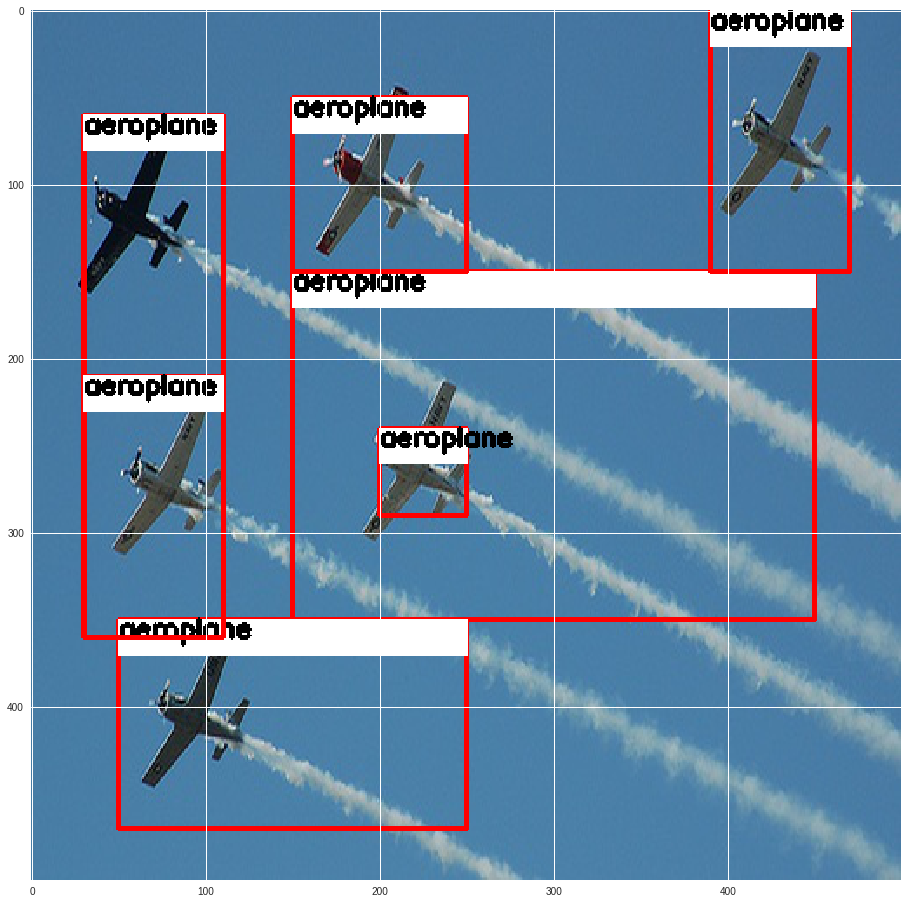

In [451]:
plot_image(sample, c_boxes, c_probs)

In [0]:
def get_mAP(predct_boxes, ground_boxes, probs):
  
  if(len(predct_boxes)==0):
    return 0
  
  ps = np.argsort(probs)[:len(predct_boxes)]
  
  tps = 0
  fps = 0
  iou_ths = [0.05,0.25,0.5,0.75]
          
  ppp = (list(predct_boxes[ps]))
  ggg = list(ground_boxes)
  
  iou_mat = np.zeros((len(ppp),len(ggg)))
  for i in range(len(ppp)):
    p_box = ppp[i]
    for j in range(len(ggg)):
      g_box = ggg[j]
      
      iou_c = compute_iou(p_box, g_box)
      vec = (iou_ths < iou_c)*1
      iou_mat[i,j] = np.mean(vec)
      
  max_row = np.mean(iou_mat, axis = 1)
          
  return np.max(max_row)

In [433]:
start = time.time()
t_boxes = {}
maps_net = []
path = test_path
for xml_path in sorted(os.listdir(path + anno))[:50]:
    tree = ET.parse(path + anno + "/" + xml_path)
    image = Image.open(path + jpeg + "/" + tree.getroot()[1].text)
    image_arr = np.array(image)
    img_n_obj=0
    
    b_boxes = {}
    for class_name in classes:
      b_boxes[class_name] = []
    
    for obj in tree.getroot().findall('object'):
        class_name = obj[0].text
        if(class_name in classes):
            img_n_obj+=1
            xmin = int(obj[4][0].text)
            ymin = int(obj[4][1].text)
            xmax = int(obj[4][2].text)
            ymax = int(obj[4][3].text)
            
            b_boxes[class_name].append(np.array([ymin,ymax,xmin,xmax]))
            
    if(img_n_obj != 0):
      t_boxes = b_boxes
      sample = image.resize((500,500), Image.ANTIALIAS)
      boxes, prs = sliding_window(sample, True)
      c_boxes, c_probs = non_maximum_supression(boxes, prs, 0.08)
      
#       print(t_boxes, c_boxes)
      
      c_maps = []
      for c in [1,2,3]:
        class_name = classes[c]
        t_boxs = (t_boxes[class_name])
        p_boxs = (c_boxes[c-1])

        if(len(t_boxs)!=0):
          b_mAP = get_mAP(p_boxs, t_boxs, c_probs[c-1])
          c_maps.append(b_mAP)
      mAP = (np.mean(c_maps))
      maps_net.append(mAP)
      print(mAP)
      
print(time.time()-start)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.0
0.08333333333333333
0.5
0.25
0.75
0.2
0.25
0.25
300.7496569156647


In [434]:
c_maps = []
for c in [1,2,3]:
  class_name = classes[c]
  t_boxs = (t_boxes[class_name])
  p_boxs = (c_boxes[c-1])

  if(len(t_boxs)!=0):
    b_mAP = get_mAP(p_boxs, t_boxs, c_probs[c-1])
    print(b_mAP)
    c_maps.append(b_mAP)
mAP = (np.mean(c_maps))
maps_net.append(mAP)
print(mAP)

0.25
0.25


In [435]:
t_boxes, c_boxes

({'__background__': [],
  'aeroplane': [],
  'bottle': [],
  'chair': [array([ 65, 278, 193, 346])]},
 [[], [], array([[260, 460, 120, 320],
         [320, 370, 140, 190],
         [200, 300, 150, 210],
         [ 60, 260,  90, 170],
         [400, 450, 320, 370],
         [120, 170, 260, 310],
         [  0,  80,  30, 180],
         [450, 500, 100, 200],
         [420, 470, 360, 410],
         [320, 370, 240, 290],
         [200, 250, 280, 330],
         [360, 410, 280, 330],
         [330, 480,  60, 140],
         [360, 410, 160, 210],
         [240, 290, 260, 310]])])

Test the trained model on the test dataset.

In [0]:
#One Layer Detection
def test(resnet18):
  # Write loops for testing the model on the test set
  # Also print out the accuracy of the model

  t_boxes = {}
  maps_net = []
  path = test_path
  mAP = 0
  for xml_path in sorted(os.listdir(path + anno)):
      tree = ET.parse(path + anno + "/" + xml_path)
      image = Image.open(path + jpeg + "/" + tree.getroot()[1].text)
      image_arr = np.array(image)
      img_n_obj=0

      b_boxes = {}
      for class_name in classes:
        b_boxes[class_name] = []

      for obj in tree.getroot().findall('object'):
          class_name = obj[0].text
          if(class_name in classes):
              img_n_obj+=1
              xmin = int(obj[4][0].text)
              ymin = int(obj[4][1].text)
              xmax = int(obj[4][2].text)
              ymax = int(obj[4][3].text)

              b_boxes[class_name].append(np.array([ymin,ymax,xmin,xmax]))

      if(img_n_obj != 0):
        t_boxes = b_boxes
        sample = image.resize((500,500), Image.ANTIALIAS)
        boxes, prs = sliding_window(sample, True)
        try:
          c_boxes, c_probs = non_maximum_supression(boxes, prs, 0.07)
          clr(wait=True)
          print(mAP, np.mean(maps_net))
          print(xml_path)
          plot_image(image, c_boxes, c_probs)
        except:
          maps_net.append(0)
          continue

        
        c_maps = []
        for c in [1,2,3]:
          class_name = classes[c]
          t_boxs = (t_boxes[class_name])
          p_boxs = (c_boxes[c-1])

          if(len(t_boxs)!=0):
            b_mAP = get_mAP(p_boxs, t_boxs, c_probs[c-1])
            c_maps.append(b_mAP)
        mAP = (np.mean(c_maps))
        maps_net.append(mAP)
        
        
  return np.mean(maps_net)

0.2 0.2972222222222222
000085.xml


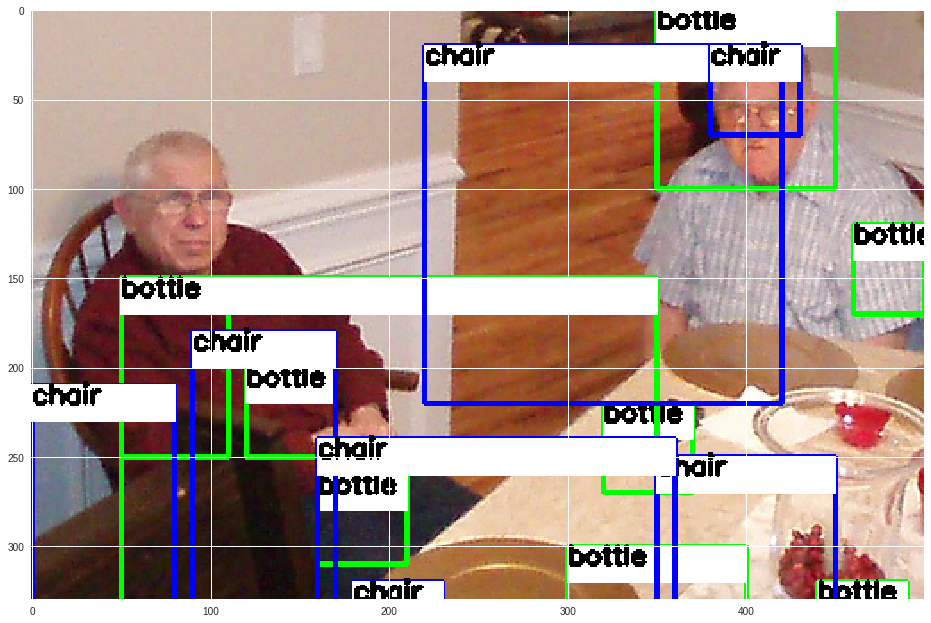

KeyboardInterrupt: ignored

In [454]:
%time test(resnet18)

In [0]:
#Two Layer Detection
def test(resnet18):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model

In [0]:
%time test(resnet18)

In [362]:
ggg = list(np.arange(10))
ggg.pop(4)
ggg

[0, 1, 2, 3, 5, 6, 7, 8, 9]